In [1]:
import sys
import os
from keras.layers import *
from keras.optimizers import *
from keras.applications import *
from keras.models import Model
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.callbacks import ModelCheckpoint
from keras import backend as k

from matplotlib.pyplot import imshow
from PIL import Image as im

Using TensorFlow backend.


In [2]:
%matplotlib inline

In [3]:
top_model_weights_path = 'my_xception.h5'

train_data_dir = 'data/train'
validation_data_dir = 'data/validation'
test_data_dir = 'data/test'
results_path = 'results/predictions'
results_name = 'predictions.csv'

nb_train_samples = 24198
nb_validation_samples = 802

In [4]:
# hyper parameters for model
nb_classes = 2  # number of classes
based_model_last_block_layer_number = 126  # value is based on based model selected.
img_width, img_height = 150, 150  # change based on the shape/structure of your images
batch_size = 16  # try 4, 8, 16, 32, 64, 128, 256 dependent on CPU/GPU memory capacity (powers of 2 values).
nb_epoch = 3  # number of iteration the algorithm gets trained.
learn_rate = 1e-4  # sgd learning rate
momentum = .9  # sgd momentum to avoid local minimum
transformation_ratio = .05  # how aggressive will be the data augmentation/transformation

In [5]:
# Pre-Trained CNN Model using imagenet dataset for pre-trained weights
base_model = Xception(input_shape=(img_width, img_height, 3), weights='imagenet', include_top=False)
print('Model Loaded!')

Model Loaded!


In [6]:
# Top Model Block
x = base_model.output
x = GlobalAveragePooling2D()(x)
predictions = Dense(nb_classes, activation='softmax')(x)

In [7]:
# add your top layer block to your base model
model = Model(base_model.input, predictions)
print(model.summary())

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 150, 150, 3)   0                                            
____________________________________________________________________________________________________
block1_conv1 (Conv2D)            (None, 74, 74, 32)    864                                          
____________________________________________________________________________________________________
block1_conv1_bn (BatchNormalizat (None, 74, 74, 32)    128                                          
____________________________________________________________________________________________________
block1_conv1_act (Activation)    (None, 74, 74, 32)    0                                            
___________________________________________________________________________________________

In [8]:
# first: train only the top layers (which were randomly initialized)
# i.e. freeze all layers of the based model that is already pre-trained.
for layer in base_model.layers:
    layer.trainable = False

In [9]:
# Read Data and Augment it: Make sure to select augmentations that are appropriate to your images.
# To save augmentations un-comment save lines and add to your flow parameters.
train_datagen = ImageDataGenerator(rescale=1. / 255,
                                   rotation_range=transformation_ratio,
                                   shear_range=transformation_ratio,
                                   zoom_range=transformation_ratio,
                                   cval=transformation_ratio,
                                   horizontal_flip=True,
                                   vertical_flip=True)

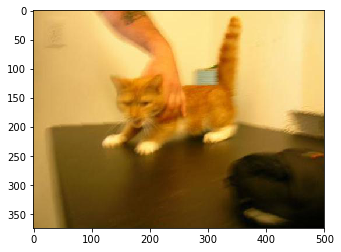

In [10]:
# preview agumented data:
img = load_img('data/train/cats/cat.0.jpg')  # this is a PIL image
x = img_to_array(img)  # this is a Numpy array with shape (3, 150, 150)
x = x.reshape((1,) + x.shape)  # this is a Numpy array with shape (1, 3, 150, 150)

# the .flow() command below generates batches of randomly transformed images
# and saves the results to the `preview/` directory
i = 0
for batch in train_datagen.flow(x, batch_size=1,
                          save_to_dir='preview', save_prefix='cat', save_format='jpeg'):
    i += 1
    if i > 20:
        break  # otherwise the generator would loop indefinitely
        
pil_im = im.open('preview/cat_0_85.jpeg', 'r')
imshow(np.asarray(pil_im))       

In [11]:
validation_datagen = ImageDataGenerator(rescale=1. / 255)

In [12]:
train_generator = train_datagen.flow_from_directory(train_data_dir,
                                                        target_size=(img_width, img_height),
                                                        batch_size=batch_size,
                                                        class_mode='categorical')

Found 24198 images belonging to 2 classes.


In [13]:
validation_generator = validation_datagen.flow_from_directory(validation_data_dir,
                                                                  target_size=(img_width, img_height),
                                                                  batch_size=batch_size,
                                                                  class_mode='categorical')

Found 802 images belonging to 2 classes.


In [14]:
model.compile(optimizer='nadam',
                  loss='categorical_crossentropy',  # categorical_crossentropy if multi-class classifier
                  metrics=['accuracy'])

In [15]:
# checkpoint
filepath="weights-improvement-{epoch:02d}-{val_acc:.2f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

In [18]:
print("\nStarting to Fine Tune Model\n")
model.fit_generator(
    train_generator,
    samples_per_epoch=nb_train_samples,
    epochs=nb_epoch,
    validation_data=validation_generator,
    nb_val_samples=nb_validation_samples,
    callbacks=callbacks_list)
print('Finished finetuning')


Starting to Fine Tune Model

Epoch 1/3


/home/flo/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:8: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<keras.pre..., epochs=3, validation_data=<keras.pre..., callbacks=[<keras.ca..., steps_per_epoch=1512, validation_steps=802)`


1512/1512 [==============================] - 216s - loss: 0.3548 - acc: 0.8426 - val_loss: 0.2032 - val_acc: 0.9231
Epoch 2/3
1512/1512 [==============================] - 225s - loss: 0.3476 - acc: 0.8475 - val_loss: 0.2055 - val_acc: 0.9273
Epoch 3/3
1512/1512 [==============================] - 218s - loss: 0.3504 - acc: 0.8451 - val_loss: 0.2034 - val_acc: 0.9328
Finished finetuning


In [19]:
# serialize model to JSON
model_json = model.to_json()
with open("model_xception.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model_xception.h5")
print("Saved model to disk")

Saved model to disk
